<a href="https://colab.research.google.com/github/pranshudiwan/NLP_CS_6200/blob/main/LSTM_With_improved_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
nltk.download('stopwords')
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Import train data
url_train = 'https://raw.githubusercontent.com/pranshudiwan/NLP_CS_6200/main/train.csv'
tweet = pd.read_csv(url_train)

# Import est data
url_test = 'https://raw.githubusercontent.com/pranshudiwan/NLP_CS_6200/main/test.csv'
test = pd.read_csv(url_test)

In [6]:
tweet_1 = tweet.text.values
test_1 = test.text.values
sentiments = tweet.target.values

In [7]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(tweet_1)
vocab_length = len(word_tokenizer.word_index) + 1

In [8]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [9]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [11]:
nltk.download('punkt')
longest_train = max(tweet_1, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(tweet_1), length_long_sentence, padding='post')
test_sentences = pad_sequences(
    embed(test_1), 
    length_long_sentence,
    padding='post'
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-04-24 19:31:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-24 19:31:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-24 19:31:52--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
embeddings_dictionary = dict()
embedding_dim = 200
glove_file = open('/content/drive/My Drive/glove.6B.200d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [23]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sentences, 
    sentiments, 
    test_size=0.25
)

In [25]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [26]:
model = BLSTM()
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = [X_test, y_test],
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
179/179 [==============================] - 58s 292ms/step - loss: 0.8665 - accuracy: 0.6036 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.00000, saving model to model.h5
Epoch 2/7
179/179 [==============================] - 51s 287ms/step - loss: 0.5090 - accuracy: 0.7746 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/7
179/179 [==============================] - 51s 284ms/step - loss: 0.4314 - accuracy: 0.8146 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/7
179/179 [==============================] - 51s 284ms/step - loss: 0.3852 - accuracy: 0.8423 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/7
179/179 [==============================] - 51s 283ms/step - loss: 0.3647 - accuracy: 0.8553 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

Epoch

In [30]:
lstm = BLSTM()
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 72, 200)           4540200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 72, 144)           157248    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 144)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 144)               576       
_________________________________________________________________
dropout_3 (Dropout)          (None, 144)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 72)                10440     
_________________________________________________________________
dropout_4 (Dropout)          (None, 72)               

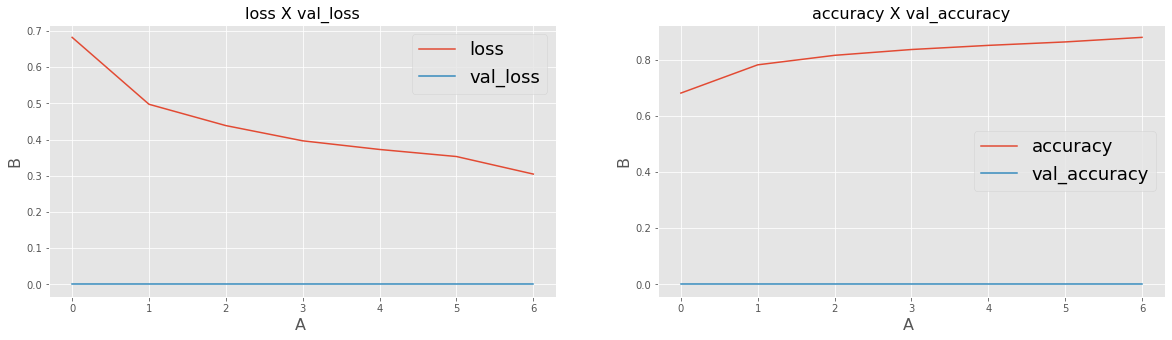

In [27]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [28]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

60/60 [==============================] - 3s 37ms/step - loss: 0.4792 - accuracy: 0.8314
Loss: 0.4792241156101227
Accuracy: 0.8314075469970703


In [29]:
preds = model.predict_classes(X_test)
metrics(preds, y_test)

F1-score:  0.7651792245793708
Precision:  0.6845549738219895
Recall:  0.867330016583748
Acuracy:  0.8314075630252101
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1301
           1       0.68      0.87      0.77       603

    accuracy                           0.83      1904
   macro avg       0.81      0.84      0.82      1904
weighted avg       0.85      0.83      0.84      1904

